## **Lecture 14: Regression with Decision Trees**

---


> **Objective: In this lecture, we will walk through the process of using tree-based regression models to predict the bench press weight of powerlifting athletes. We will explore data preprocessing, feature selection, model training, hyperparameter tuning, and model evaluation using the BenchPress Weight dataset.**

At the beginning of our lecture series, we delved into tree-based algorithms, focusing on Random Forests, Gradient Boosting Trees, and Decision Trees. We primarily explored these models within the framework of classification problems. Now, in this notebook, we will shift our attention to their regression counterparts. Despite this change in application, the fundamental principles driving these algorithms remain unchanged.


## Background

Powerlifting is a strength sport that consists of three attempts at maximal weight on three lifts: squat, bench press, and deadlift. Each lift plays a significant role in the overall performance of an athlete and contributes to their total score. Bench press performance, while influenced by a range of factors, has been shown to correlate with body weight, as well as the strength demonstrated in squat and deadlift movements.

Regression analysis, particularly with tree-based models like Decision Trees, Random Forest, and Gradient Boosted Trees, provides valuable insights into the relationships between these variables. These models can capture non-linear patterns and interactions between features, making them suitable for predicting the bench press weight based on the given features.


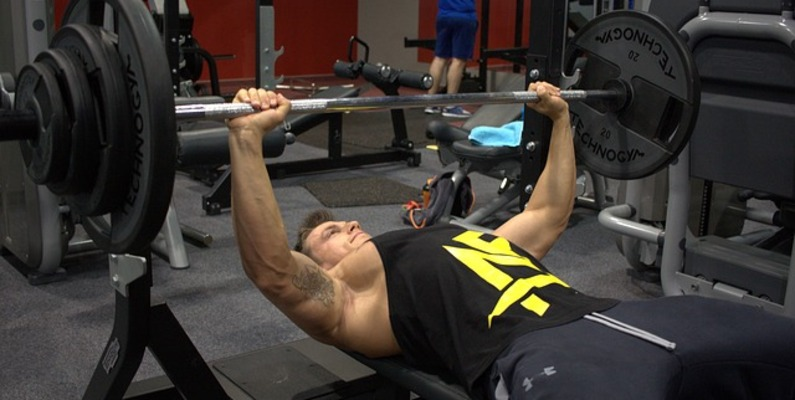

## Dataset
The BenchPress Weight dataset is a comprehensive collection of powerlifting metrics designed for the exploration and prediction of bench press performance. The dataset includes key variables that are typically associated with the bench press, which is one of the three lifts in the sport of powerlifting.

The main objective of the dataset is to facilitate the understanding and prediction of how much weight an athlete can bench press based on their body weight and performance in other lifts, specifically the squat and deadlift.

Key features of the dataset include:

 - `playerId`: A unique identifier for each athlete.
- `Name`: The name of the athlete.
- `Sex`: The sex of the athlete (male/female).
- `Equipment`: The type of equipment used by the athlete (e.g., raw, wraps, single-ply, multi-ply).
- `Age`: The age of the athlete.
- `BodyweightKg`: The body weight of the athlete in kilograms.
- `BestSquatKg`: The best squat weight lifted by the athlete in kilograms.
- `BestDeadliftKg`: The best deadlift weight lifted by the athlete in kilograms.
- `BestBenchKg`: The target variable for the regression analysis, which is the best bench press weight that an athlete can possibly handle.

Let's start by loading our dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os
os.chdir("drive/MyDrive/Pierrepont 2024/Intro to ML/datasets")

In [ ]:
import pandas as pd
import numpy as np

#Load dataset
X_train = pd.read_csv("powerlifting_dataset/X_train.csv")
X_test = pd.read_csv("powerlifting_dataset/X_test.csv")
y_train = pd.read_csv("powerlifting_dataset/y_train.csv")
y_test = pd.read_csv("powerlifting_dataset/y_test.csv")

In [ ]:
#Preview the dataset
X_train.head(4)

,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg
0,19391.0,Carlos Ceron,M,Raw,23.0,87.30,205.0,235.0
1,15978.0,Tito Herrera,M,Wraps,23.0,73.48,220.0,260.0
2,27209.0,Levi Lehman,M,Raw,26.0,112.40,142.5,220.0
3,27496.0,Stacy Hayford,F,Raw,35.0,59.42,95.0,102.5


In [ ]:
y_train.head(4)

,playerId,BestBenchKg
0,19391.0,125.0
1,15978.0,157.5
2,27209.0,145.0
3,27496.0,60.0


In [ ]:
X_test.head(4)

,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg
0,2308.0,Peter Neeves,M,Wraps,30.0,89.81,179.17,192.78
1,22404.0,Josh Padilla,M,Raw,27.0,74.95,125.00,165.00
2,23397.0,Luke Dreier,M,Wraps,30.0,122.61,290.00,317.50
3,25058.0,Jacob New,M,Raw,20.0,88.00,187.50,240.00


In [ ]:
y_test.head(4)

,playerId,BestBenchKg,Age,BodyweightKg,BestDeadliftKg
0,2308.0,97.52,NaN,NaN,NaN
1,22404.0,75.00,NaN,NaN,NaN
2,23397.0,190.00,NaN,NaN,NaN
3,25058.0,117.50,NaN,NaN,NaN


In `y_test`, we have identified redundant instances of `Age`, `BodyweightKg`, and `BestDeadliftKg`. To ensure the integrity of our analysis and avoid the potential biases associated with duplicated data, we will proceed by removing these repeated entries.

In [ ]:
y_test.drop(columns = ["Age",	"BodyweightKg",	"BestDeadliftKg"],inplace=True)
y_test.head(4)

,playerId,BestBenchKg
0,2308.0,97.52
1,22404.0,75.00
2,23397.0,190.00
3,25058.0,117.50


## Preprocess & Check Data

Next, it's important to note that both the feature dataframe (X) and the target dataframe (Y) share a common linking attribute, namely `playerId`. To ensure data integrity and consistency, we must verify that the `playerId` order is maintained across both the feature and target dataframes for the training and test sets. Preserving this sequence is crucial for maintaining the correct alignment between the data and their corresponding ground truth values.

In [ ]:
print(np.sum(X_test["playerId"].values == y_test['playerId']) == X_test.shape[0])
print(np.sum(X_train["playerId"].values == y_train['playerId']) == X_train.shape[0])

True
True


Let's take a deeper look at our dataset.

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   playerId        18900 non-null  float64
 1   Name            18900 non-null  object 
 2   Sex             18900 non-null  object 
 3   Equipment       18900 non-null  object 
 4   Age             18725 non-null  float64
 5   BodyweightKg    18900 non-null  float64
 6   BestSquatKg     18900 non-null  object 
 7   BestDeadliftKg  18900 non-null  float64
dtypes: float64(4), object(4)
memory usage: 1.2+ MB


We noticed that the `BestSquatKg` feature is represented with the inapprpriate datatype. So let's investigate and then convert it to the appropriate data type.

In [ ]:
def convert(x):
    try:
        x = float(x)
    except:
        return x
    return x

BestSquatKg_dtype = [*map(lambda x : type(convert(x)) != float, X_train['BestSquatKg'].unique())]
BestSquatKg_dtype2 = [*map(lambda x : type(convert(x)) != float, X_test['BestSquatKg'].unique())]

wrong_train_data = X_train['BestSquatKg'].unique()[BestSquatKg_dtype]
wrong_test_data = X_test['BestSquatKg'].unique()[BestSquatKg_dtype2]

wrong_train_data, wrong_test_data

(array(['102..5', '227..5', '133..0', '192..5', '105..0', '195..0',
        '237..5', '122..5', '295..0', '180..0', '205..0', '110..0',
        '220..0', '145..0', '207..5'], dtype=object),
 array([], dtype=float64))

It seems that the test data doesn't contain the erroneous entries. We can observe that the erroneous entries have additional dots in some number. We can simply just remove this additional dots to move on.

In [ ]:
correct_train_data = np.array([*map(lambda x : x[:-2] + x[-1], wrong_train_data)])
correct_train_data = correct_train_data.astype('float')
for i in range(len(wrong_train_data)):
    X_train.loc[X_train['BestSquatKg'] == wrong_train_data[i], 'BestSquatKg'] = correct_train_data[i]

X_train['BestSquatKg'] = X_train['BestSquatKg'].astype('float')
X_train['BestSquatKg'].dtype

dtype('float64')

Additionally, we can see that the `Age` feature contains some missing values.

In [ ]:
X_train['Age'].describe()

count    18725.00000
mean        29.66470
std         11.55708
min          7.00000
25%         21.50000
50%         26.50000
75%         35.00000
max         83.00000
Name: Age, dtype: float64

<Axes: xlabel='Age', ylabel='Count'>

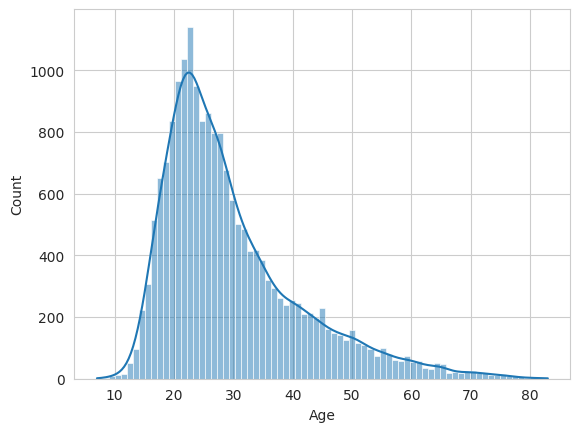

In [ ]:
# Plot histogram
import seaborn as sns
sns.histplot(data = X_train['Age'], kde = True)

Based on the histogram, the data for `Age` appears to be right-skewed, which means that there are more observations at the lower end of the age spectrum and fewer as age increases. We can see that the peak of the distribution is towards the younger end, with a tail stretching out towards the older ages.

A good choice for replacing the missing values in the `Age` would be mean, as it is more robust to outliers and may represent the central tendency of the distribution more effectively.

- **Note:** To prevent data leakage, **it is crucial that we use the mean age derived from the training set to impute missing age values in the test set**. This ensures that the imputation strategy does not inadvertently incorporate information from the test set, which should remain unseen during the model training process.

In [ ]:
mean_age = X_train['Age'].mean()

#handle train data
X_train['Age'].fillna(mean_age,inplace=True)
#handle test data
X_test['Age'].fillna(mean_age,inplace=True)

#### Check for Duplicates
Next, we will check the dataset to see if there are any duplicated rows.

In [ ]:
print(X_train.duplicated().sum())
print(X_test.duplicated().sum())

0
0


There are no duplicates in our dataset.

Before going into Exploratory Data Analysis. We should join the target and input features in our training and testing set.

In [ ]:
input_features = pd.concat([X_train,X_test], axis=0)
targets = pd.concat([y_train,y_test], axis=0)

In [ ]:
input_features.describe()

,playerId,Age,BodyweightKg,BestSquatKg,BestDeadliftKg
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,14999.500000,29.678589,85.359097,178.249505,201.114296
std,8660.398374,11.494781,22.881926,71.788046,62.369995
min,0.000000,7.000000,24.100000,-330.000000,18.100000
25%,7499.750000,21.500000,68.050000,122.500000,147.500000
50%,14999.500000,26.500000,82.100000,175.000000,204.120000
75%,22499.250000,34.500000,98.880000,222.500000,247.500000
max,29999.000000,89.500000,242.400000,532.970000,420.500000


We can see that some of the weight related features are negative , which is not possible. It is possible that these values were entered wrongly with a negative sign. So, we will convert them to positive by taking the absolute value.

In [ ]:
kg_features = input_features.filter(regex='Kg').columns
input_features[kg_features] = np.abs(input_features[kg_features])

The `name` and `playerId` features has no significant value in our analysis. Hence, we will drop these columns.

In [ ]:
input_features.drop(columns =["Name","playerId"],inplace=True)
targets.drop(columns =["playerId"],inplace=True)

## Exploratory Data Analysis

In this section, you will perform Exploratory Data Analysis (EDA) on the provided powerlifting dataset. We have outlined five questions for you to investigate. For each question, we've provided hints to help you approach your analysis effectively. Utilize plots and statistical summaries where appropriate to draw insights from the data.

In [ ]:
train_ = input_features.iloc[:X_train.shape[0],:]
target_ = targets.iloc[:X_train.shape[0]]

### Question 1: What is the distribution of BestBenchKg among the lifters?

*Hint: Consider plotting a histogram or density plot to visualize the distribution of `BestBenchKg`. Pay attention to the shape, spread, and any potential outliers in the data.*

### Solution

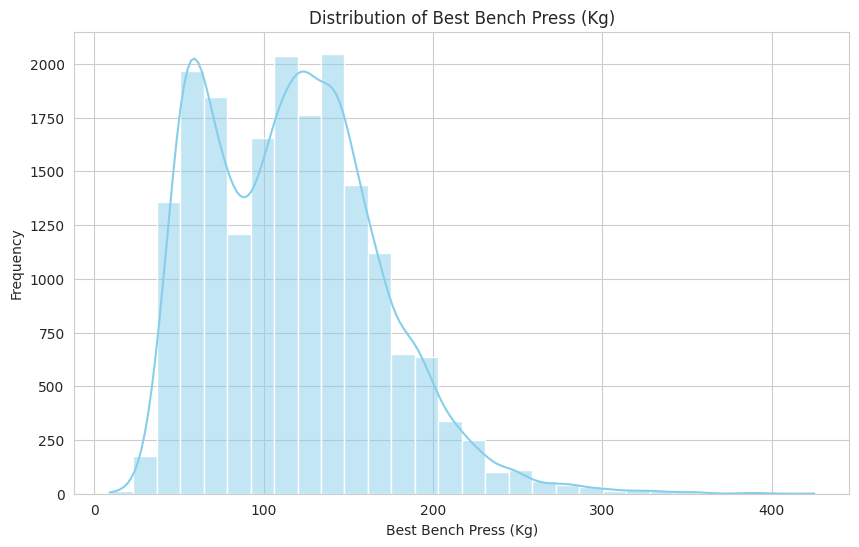

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set_style("whitegrid")

# Plot the distribution of BestBenchKg
plt.figure(figsize=(10, 6))
sns.histplot(target_['BestBenchKg'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Best Bench Press (Kg)')
plt.xlabel('Best Bench Press (Kg)')
plt.ylabel('Frequency')
plt.show()


#### Insights
- The distribution appears to be bi-modal, indicating that there might be two groups of athletes: those who can benchpress between 0 and 100kg and those who can benchpress over 100kg.
- The long tail to the right suggests that there are some lifters who achieve exceptionally high bench press weights, but they are relatively rare.

### Question 2: How does the BestBenchKg vary between male and female lifters?

*Hint: Use box plots to compare the distribution of `BestBenchKg` between male and female lifters. Look for differences in the central tendency, variability, and range.*

In [ ]:
## Your implementation here

### Solution


<ipython-input-26-b944e580cdc8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_['Sex'], y=target_['BestBenchKg'], palette='coolwarm')


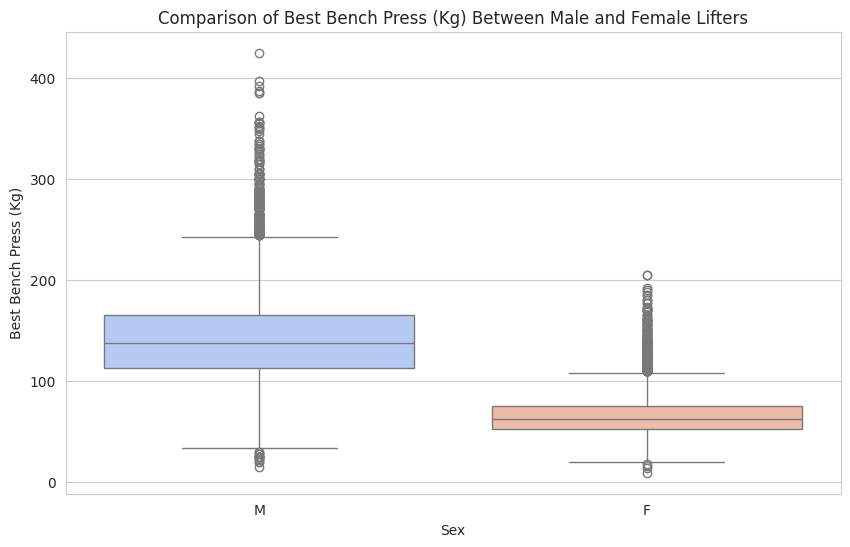

In [ ]:
# Plot the distribution of BestBenchKg between male and female lifters
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_['Sex'], y=target_['BestBenchKg'], palette='coolwarm')
plt.title('Comparison of Best Bench Press (Kg) Between Male and Female Lifters')
plt.xlabel('Sex')
plt.ylabel('Best Bench Press (Kg)')
plt.show()


From the plot, we can observe the following:

1. The median `BestBenchKg` for male lifters is higher than that for female lifters, as indicated by the position of the horizontal line within each box.
2. The interquartile range (IQR), represented by the height of each box, is wider for male lifters, suggesting more variability in bench press performances among men compared to women.
3. Both distributions have outliers, as indicated by the points outside the whiskers of each box plot, but the male lifters' outliers extend to much higher `BestBenchKg` values.
4. The overall range of `BestBenchKg`, from the minimum to the maximum excluding outliers, is broader for male lifters.

### Question 3: Is there a relationship between BodyweightKg and BestBenchKg?

*Hint: Create a scatter plot with a trend line to explore the relationship between BodyweightKg and BestBenchKg. Additionally look at the correlation coefficient to determine the strength of the relationship. Consider how body weight might influence bench press performance.*

In [ ]:
#Your implementation here

### Solution

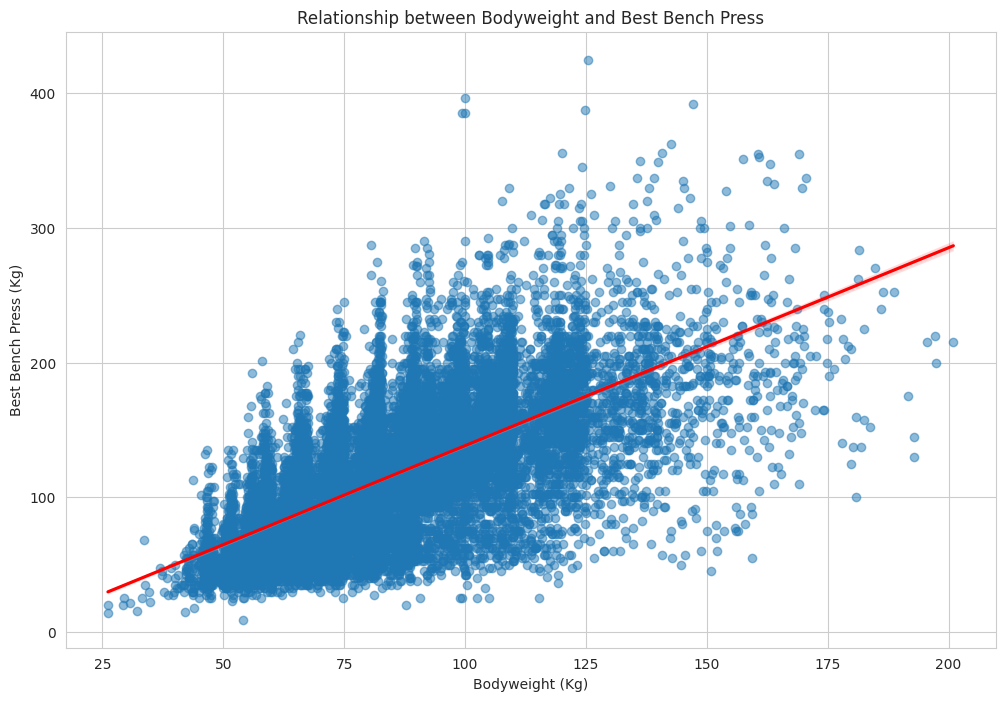

Correlation Matrix between Bodyweight and Best Bench Press
 [[1.         0.65875301]
 [0.65875301 1.        ]]


In [ ]:
#solution
plt.figure(figsize=(12, 8))
sns.regplot(x=train_['BodyweightKg'], y=target_['BestBenchKg'], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relationship between Bodyweight and Best Bench Press')
plt.xlabel('Bodyweight (Kg)')
plt.ylabel('Best Bench Press (Kg)')
plt.show()


print(f"Correlation Matrix between Bodyweight and Best Bench Press\n {np.corrcoef(train_['BodyweightKg'],target_['BestBenchKg'])}")

From the plot, we can observe the following:

1. There appears to be a positive correlation between `BodyweightKg` and `BestBenchKg`, as indicated by the upward slope of the trend line. This suggests that, on average, lifters with higher body weights tend to have better bench press performances.
2. The scatter of points shows a wide range of `BestBenchKg` values at most body weights, indicating variability in bench press performance that cannot be explained by body weight alone.
3. The density of points is higher at lower body weights, suggesting that there are more lifters within these weight categories in the dataset.

### Question 4: How does the choice of Equipment (e.g., Raw, Wraps) affect `BestBenchKg`?

*Hint: Compare the average or median BestBenchKg across different equipment categories using bar plots. Reflect on how equipment might enhance or affect performance.*

In [ ]:
## Your Implementation Here

### Solution

<ipython-input-31-a51eeb015917>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=train_['Equipment'], y=target_['BestBenchKg'], ci=None, palette='Set2')
<ipython-input-31-a51eeb015917>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_['Equipment'], y=target_['BestBenchKg'], ci=None, palette='Set2')


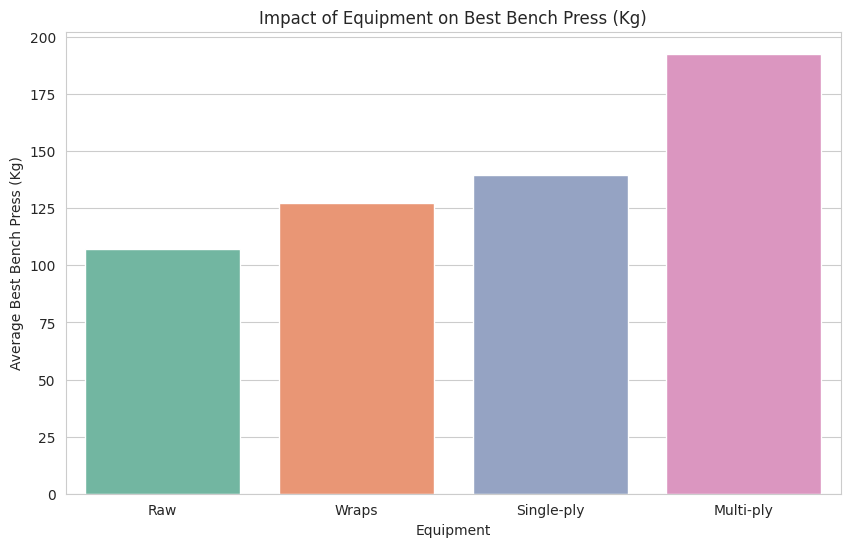

In [ ]:
#solution
plt.figure(figsize=(10, 6))
sns.barplot(x=train_['Equipment'], y=target_['BestBenchKg'], ci=None, palette='Set2')
#sns.boxplot(x=train_['Equipment'], y=target_['BestBenchKg'], palette='Set2')
plt.title('Impact of Equipment on Best Bench Press (Kg)')
plt.xlabel('Equipment')
plt.ylabel('Average Best Bench Press (Kg)')
plt.show()


From the plot, we can observe:

1. There are noticeable differences in the average `BestBenchKg` across the different equipment categories. Some categories show higher average bench press weights than others, suggesting that the choice of equipment could influence bench press performance.
2. The equipment category labeled `Raw` likely represents lifters who do not use supportive gear like bench shirts or wraps, while other categories might indicate the use of various supportive equipment, which can aid in lifting heavier weights.

### Question 5: Is there a noticeable difference in BestBenchKg across different age groups?

*Hint: Creating age groups: { (18 and under), (19-23), (24-38), (39-49), (50-59), (60-69), and (70+)} and analyze the average `BestBenchKg` within each. Use bar plots or box plots to visualize how age may impact performance*

In [ ]:
## Your implementation here

### Solution

<ipython-input-32-907df08404a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_['AgeGroup'] = pd.cut(train_['Age'], bins=age_bins, labels=age_labels, right=False)
<ipython-input-32-907df08404a5>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=train_['AgeGroup'], y= target_['BestBenchKg'], ci=None, palette='viridis')
<ipython-input-32-907df08404a5>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_['AgeGroup'], y= target_['BestBenchKg'], ci=None, palette='viridis')


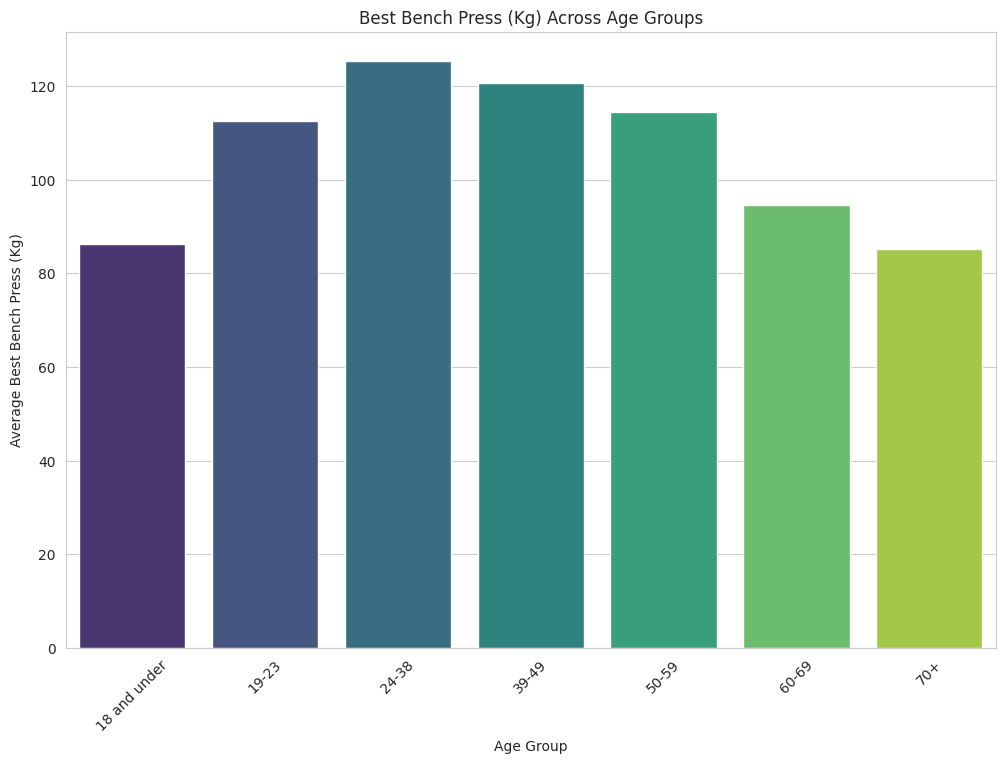

In [ ]:
# Define age bins and labels
age_bins = [0, 18, 23, 38, 49, 59, 69, float('inf')]
age_labels = ['18 and under', '19-23', '24-38', '39-49', '50-59', '60-69', '70+']

# Categorize the data into age groups
train_['AgeGroup'] = pd.cut(train_['Age'], bins=age_bins, labels=age_labels, right=False)

# Plot the average BestBenchKg across age groups
plt.figure(figsize=(12, 8))
sns.barplot(x=train_['AgeGroup'], y= target_['BestBenchKg'], ci=None, palette='viridis')
plt.title('Best Bench Press (Kg) Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Average Best Bench Press (Kg)')
plt.xticks(rotation=45)
plt.show()


From the plot, we can observe:

1. There are differences in the average BestBenchKg across age groups, indicating that age might have an impact on bench press performance.
2. The age groups of "24-38" and "39-49" seem to have higher average BestBenchKg compared to the younger and older age groups. This could suggest that lifters in these age ranges are, on average, stronger or more experienced in bench pressing.
3. The youngest (18 and under) and the oldest (70+) age groups tend to have lower average BestBenchKg, which could reflect less muscle mass or strength due to age, less training experience in the case of younger lifters, or age-related decline in the case of older lifters.

## Feature Engineering

Feature engineering is a critical step in improving model performance, especially in regression tasks where the relationships between features can provide meaningful insights. Although our initial dataset includes `Sex`, `Equipment`, `Age`, `BodyweightKg`, `BestSquatKg`, `BestDeadliftKg`, and the target `BestBenchKg`. It is possible to engineer new features.






In [ ]:
data_df = pd.concat([input_features,targets],axis=1)
data_df.head()

,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg
0,M,Raw,23.0,87.30,205.0,235.0,125.0
1,M,Wraps,23.0,73.48,220.0,260.0,157.5
2,M,Raw,26.0,112.40,142.5,220.0,145.0
3,F,Raw,35.0,59.42,95.0,102.5,60.0
4,F,Raw,26.5,61.40,105.0,127.5,60.0


1. **Relative Strength:** Calculate the relative strength index by dividing the lift weights (BestSquatKg and BestDeadliftKg) by the BodyweightKg. This normalizes the lifts by body weight, which is often a more accurate indicator of strength.




In [ ]:
# Calculate relative strength by dividing the lift weights by the body weight
data_df['RelativeSquatStrength'] = data_df['BestSquatKg'] / data_df['BodyweightKg']
data_df['RelativeDeadliftStrength'] = data_df['BestDeadliftKg'] / data_df['BodyweightKg']

2. **Equipment Index:** In powerlifting, the type of equipment used can significantly influence a lifter's performance due to the support and mechanical advantage provided by the gear. We can rank the different equipment types based on known impact on bench press performance. We will assign an index or score to each equipment type based on their expected influence on lifting ability. 'Multi-ply' equipment is considered to provide the most support, followed by 'Single-ply', then 'Wraps', with 'Raw' providing no additional support.


In [ ]:
# Define the mapping from equipment type to index
equipment_scores = {
    'Raw': 1,
    'Wraps': 2,
    'Single-ply': 3,
    'Multi-ply': 4
}

# Map the equipment types to their respective scores
data_df['Equipment_Index'] = data_df['Equipment'].map(equipment_scores)

3. **Categorical Variable Encoding**: We will endoe the `Sex` and `Equipment` variables using One hot Encoding.


In [ ]:
#Check unique categories in categorical columns
data_df["Equipment"].unique(), data_df['Sex'].unique()

(array(['Raw', 'Wraps', 'Single-ply', 'Multi-ply'], dtype=object),
 array(['M', 'F'], dtype=object))

Next we will use `pd.get_dummies` to convert categorical variable into dummy/indicator variables. We will also drop the first category to avoid the dummy variable trap.

In [ ]:
data_df = pd.get_dummies(data_df, columns=['Equipment',"Sex"], drop_first=True)
data_df.head()

,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg,RelativeSquatStrength,RelativeDeadliftStrength,Equipment_Index,Equipment_Raw,Equipment_Single-ply,Equipment_Wraps,Sex_M
0,23.0,87.30,205.0,235.0,125.0,2.348225,2.691867,1,1,0,0,1
1,23.0,73.48,220.0,260.0,157.5,2.994012,3.538378,2,0,0,1,1
2,26.0,112.40,142.5,220.0,145.0,1.267794,1.957295,1,1,0,0,1
3,35.0,59.42,95.0,102.5,60.0,1.598788,1.725008,1,1,0,0,0
4,26.5,61.40,105.0,127.5,60.0,1.710098,2.076547,1,1,0,0,0


4. **Age Category**: Instead of using the continuous Age feature, we could categorize athletes into age groups. The International Powerlifting Federation (IPF) uses the following age categories:
- sub-junior (18 and under)
- junior (18-23)
- open (24-38)
- masters 1 (39-49)
- masters 2 (49-59)
- masters 3 (59-69)
- masters 4 (69+)

This can help capture different performance trends across age ranges.

In [ ]:
# Define the bins for the age categories
bins = [0, 18, 23, 38, 49, 59, 69, np.inf]
labels = ['Sub-Junior', 'Junior', 'Open', 'Masters 1', 'Masters 2', 'Masters 3', 'Masters 4']

# Bin the age data
data_df['AgeCategory'] = pd.cut(data_df['Age'], bins=bins, labels=labels, right=False)
data_df['AgeCategory']

0          Open
1          Open
2          Open
3          Open
4          Open
          ...  
11095      Open
11096      Open
11097    Junior
11098      Open
11099    Junior
Name: AgeCategory, Length: 30000, dtype: category
Categories (7, object): ['Sub-Junior' < 'Junior' < 'Open' < 'Masters 1' < 'Masters 2' < 'Masters 3' <
                         'Masters 4']

Now we will encode these categories using scikit-learn's [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

Ordinal encoding is a feature transformation technique used to convert categorical data that has a natural order or ranking (like 'low', 'medium', 'high') into numerical format. This process assigns each unique category value to an integer based on their order or rank, which is essential for allowing algorithms to interpret the data during modeling.

In [ ]:
# Now we will use OrdinalEncoder to encode these categories
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[labels])
data_df['AgeCategoryEncoded'] = ordinal_encoder.fit_transform(data_df[['AgeCategory']])
data_df['AgeCategoryEncoded']

0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
11095    2.0
11096    2.0
11097    1.0
11098    2.0
11099    1.0
Name: AgeCategoryEncoded, Length: 30000, dtype: float64

In [ ]:
data_df.head(3)

,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg,RelativeSquatStrength,RelativeDeadliftStrength,Equipment_Index,Equipment_Raw,Equipment_Single-ply,Equipment_Wraps,Sex_M,AgeCategory,AgeCategoryEncoded
0,23.0,87.30,205.0,235.0,125.0,2.348225,2.691867,1,1,0,0,1,Open,2.0
1,23.0,73.48,220.0,260.0,157.5,2.994012,3.538378,2,0,0,1,1,Open,2.0
2,26.0,112.40,142.5,220.0,145.0,1.267794,1.957295,1,1,0,0,1,Open,2.0


## Model Development: Building the Regression Model

For the sake of inference speed and hardware limitation. We will restrict the test set to the last 5000 examples.

In [ ]:
target = data_df['BestBenchKg']
input_features = data_df.drop(columns =["BestBenchKg","Age","AgeCategory"])

#Targets
y_train, y_test = target.iloc[:X_train.shape[0]],target.iloc[-5000:]
#Input features
X_train, X_test =  input_features.iloc[:X_train.shape[0],:], input_features.iloc[-5000:,:]

print(X_train.shape, X_test.shape), print(y_train.shape, y_test.shape)

(18900, 11) (5000, 11)
(18900,) (5000,)


(None, None)

In order to measure the performance of our models, we will utilize evaluation metrics such as the root mean squared error and the R2 score.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate(train_predictions, test_predictions):

    r2_train = r2_score(train_predictions, y_train)
    r2_test = r2_score(test_predictions, y_test)
    print(f"R2:\nTrain: {r2_train}, Test: {r2_test}")

    rmse_train = np.sqrt(mean_squared_error(train_predictions, y_train))
    rmse_test = np.sqrt(mean_squared_error(test_predictions, y_test))
    print(f"RMSE:\nTrain: {rmse_train}, Test: {rmse_test}")

We will also create a function `plot_feature_importance`, this function will help us visualize the most relevant features towards prediction.

In [ ]:
from matplotlib import pyplot as plt
def plot_feature_importance(importance, names, model_name):
    #create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # create a dataframe using a dictionary
    data = {'feature_names':feature_names, 'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'],ascending = False, inplace=True)

    #define size of bar plot
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y = fi_df['feature_names'])
    plt.title(model_name + "FEATURE IMPORTANCE")

    #Add chart labels
    plt.xlabel("FEATURE IMPORTANCE")
    plt.ylabel("FEATURE NAMES")

### **Class Discussion**

---

> **Do tree-based regression models like Decision Trees and Random Forests require feature scaling to perform effectively?**

Feature scaling, which involves standardizing or normalizing features, is not strictly necessary for tree-based regression models such as Decision Trees and Random Forests. This is because these models make decisions based on thresholds and do not compute distances between points or assume a particular distribution of the features. As a result, the scale of the features does not impact the model's ability to split nodes and make predictions. However, in some scenarios, especially when integrating tree-based models with other algorithms that do require feature scaling, or when using certain visualization or analysis techniques, scaling might still be beneficial for consistency or interpretability.

## Tree-Based Regression Models

Tree-based regression models are a subset of machine learning algorithms that use a decision tree structure to predict continuous outcomes based on input features. These models split the data into subsets using decision rules inferred from the features, effectively breaking down a complex regression problem into simpler, more manageable parts. The final prediction for a given input is typically the average target value of the training instances within the same leaf node.

Key characteristics include:

1. **Hierarchical Structure:** The decision tree starts with a root node and branches out into internal nodes and leaf nodes, representing decision points and outcomes, respectively.

2. **Non-Linearity:** Tree-based models can capture non-linear relationships between features and the target variable without requiring transformations.

3. **Feature Importance:** These models can inherently provide insights into the importance of each feature in predicting the target variable.

4. **Versatility:** They can handle both numerical and categorical data and do not require feature scaling.


Common tree-based regression models include:

1. **Decision Tree Regression:** Utilizes a single decision tree, making it simple and interpretable but prone to overfitting.

2. **Random Forest Regression:** Builds multiple decision trees and aggregates their predictions to improve accuracy and robustness.

3. **Gradient Boosting Trees:** Constructs sequential trees where each tree attempts to correct the errors of the previous one, often leading to high performance.


For a recap on the inner working of these algorithms, please revisit [lecture 05](https://colab.research.google.com/drive/1Yd34Jg3bnV3kD3n20XfBnGU3iMyIuyt_)

 - **Note:** <font color="darkred">Tree-based regression models are widely used due to their interpretability, ease of use, and effectiveness in handling various types of data. However, they can be susceptible to overfitting, especially with complex trees, and might require careful tuning of hyperparameters to achieve the best performance.</font>



### Decision Trees

In [ ]:
from sklearn.tree import  DecisionTreeRegressor

dtc_model =  DecisionTreeRegressor(random_state=23, max_depth=7)

dtc_model.fit(X_train, y_train)

dtc_train_predictions = dtc_model.predict(X_train)
dtc_test_predictions = dtc_model.predict(X_test)

evaluate(dtc_train_predictions, dtc_test_predictions)

R2:
Train: 0.8626241210054661, Test: 0.7097867659086101
RMSE:
Train: 17.804512964055586, Test: 25.57968984448164


In [ ]:
importances = dtc_model.feature_importances_

# Print the importance of each feature
for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance:.4f}")

BodyweightKg: 0.0083
BestSquatKg: 0.8779
BestDeadliftKg: 0.0100
RelativeSquatStrength: 0.0010
RelativeDeadliftStrength: 0.0034
Equipment_Index: 0.0054
Equipment_Raw: 0.0008
Equipment_Single-ply: 0.0006
Equipment_Wraps: 0.0001
Sex_M: 0.0842
AgeCategoryEncoded: 0.0082


Let's visualize the top features.


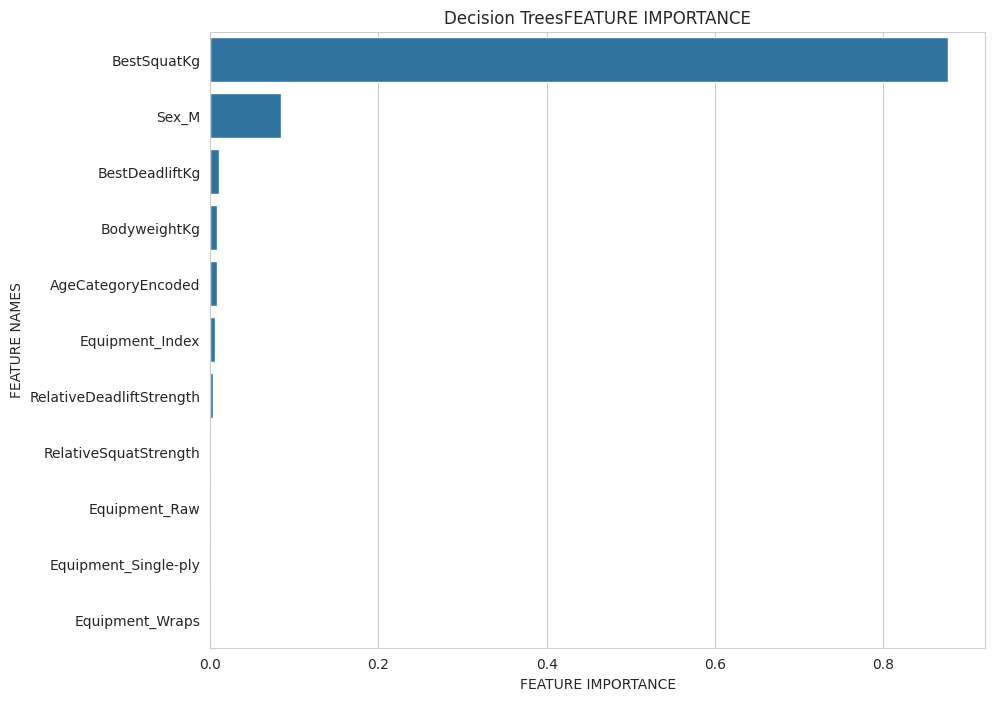

In [ ]:
plot_feature_importance(importances , names = X_train.columns, model_name= "Decision Trees")

Given our model performance, there is still room for improvement.
#### Hyper-parameter Optimization

- **Task:** Your task is to enhance the performance of your Decision Tree model by utilizing either RandomizedSearchCV or GridSearchCV for hyperparameter optimization. Begin by selecting the parameters you wish to tune. After determining the optimal parameter values through the search process, instantiate a new Decision Tree model using these optimized parameters. Then, evaluate and compare the performance of this optimized model against the original to assess the improvement achieved.

Find the list of parameters in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).

In [ ]:
#To-Do: Hyper-parameter Optimization


### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RF_model = RandomForestRegressor(random_state=34,n_estimators=500, min_samples_leaf=40,
                                 min_samples_split=90, n_jobs=-1, max_features="sqrt")

RF_model.fit(X_train, y_train)

RF_train_predictions = RF_model.predict(X_train)
RF_test_predictions = RF_model.predict(X_test)

evaluate(RF_train_predictions, RF_test_predictions)

R2:
Train: 0.8552950400851871, Test: 0.7119488741680712
RMSE:
Train: 17.7354277398598, Test: 24.686752502697345


In [ ]:
importances = RF_model.feature_importances_

# Print the importance of each feature
for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance:.4f}")

BodyweightKg: 0.1005
BestSquatKg: 0.3602
BestDeadliftKg: 0.2850
RelativeSquatStrength: 0.0553
RelativeDeadliftStrength: 0.0220
Equipment_Index: 0.0165
Equipment_Raw: 0.0066
Equipment_Single-ply: 0.0031
Equipment_Wraps: 0.0015
Sex_M: 0.1417
AgeCategoryEncoded: 0.0076


Let's visualize the top features.


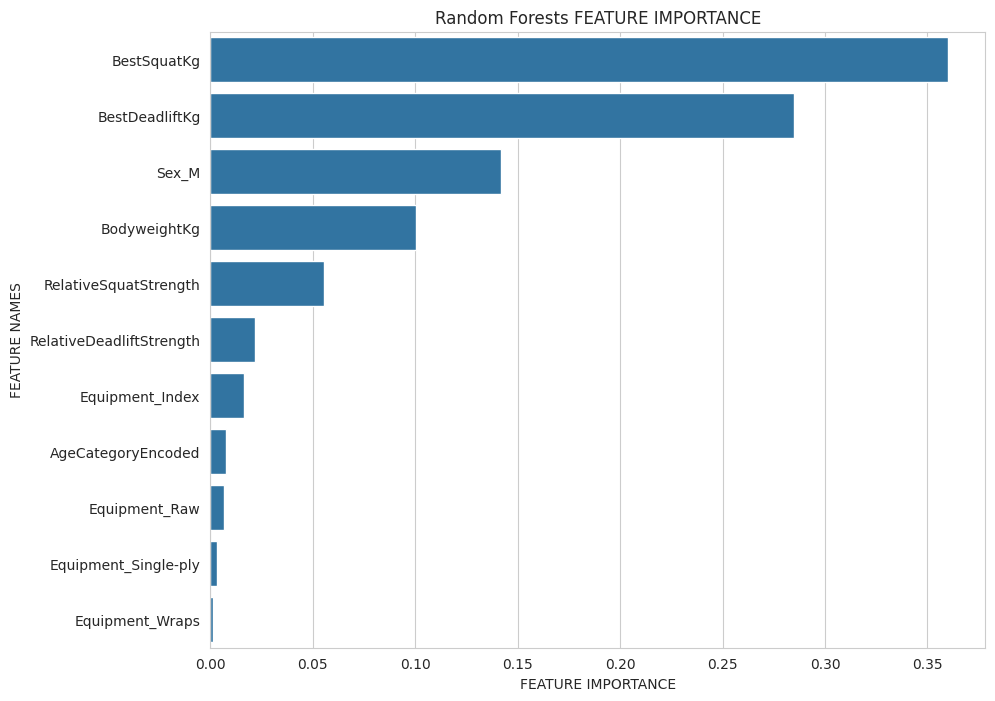

In [ ]:
plot_feature_importance(importances , names = X_train.columns, model_name= "Random Forests ")

Given our model performance, there is still room for improvement.
#### Hyper-parameter Optimization

- **Task:** Your task is to enhance the performance of your Random Forest model by utilizing either RandomizedSearchCV or GridSearchCV for hyperparameter optimization. Begin by selecting the parameters you wish to tune. After determining the optimal parameter values through the search process, instantiate a new Random Forest model using these optimized parameters. Then, evaluate and compare the performance of this optimized model against the original to assess the improvement achieved.

Find the list of parameters in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html_).

In [ ]:
#To-Do: Hyper-parameter Optimization


### Gradient Boosting Trees

Gradient Boosting is a machine learning technique that builds models incrementally in a stage-wise fashion. It combines the predictions from multiple weak learners (typically decision trees) to create a strong learner that performs better than any of the individual models. The concept of boosting involves sequentially adding weak learners, where each new model focuses on correcting the errors made by the previous ones. In Gradient Boosting, this correction is guided by the gradient of the loss function, which indicates the direction in which the model should be improved, hence the name "Gradient" Boosting.


The implementation in scikit-learn has a lot of overlapping parameters with Random Forests. The hyper-parameters have the same meaning and functions.

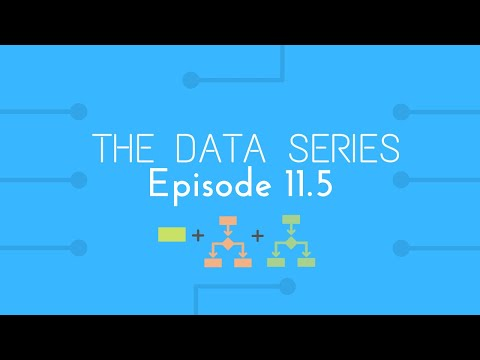

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('zTXVo2Kmi8Q', width=800, height=500)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

GBM_model = GradientBoostingRegressor(max_depth=3,random_state=85)

GBM_model.fit(X_train, y_train)

GBM_train_predictions = GBM_model.predict(X_train)
GBM_test_predictions = GBM_model.predict(X_test)

evaluate(GBM_train_predictions, GBM_test_predictions)

R2:
Train: 0.8728155233542739, Test: 0.730660546355844
RMSE:
Train: 17.100953575747923, Test: 24.556589549419776


In [ ]:
importances = GBM_model.feature_importances_

# Print the importance of each feature
for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance:.4f}")

BodyweightKg: 0.0159
BestSquatKg: 0.6265
BestDeadliftKg: 0.2915
RelativeSquatStrength: 0.0031
RelativeDeadliftStrength: 0.0023
Equipment_Index: 0.0104
Equipment_Raw: 0.0000
Equipment_Single-ply: 0.0004
Equipment_Wraps: 0.0001
Sex_M: 0.0413
AgeCategoryEncoded: 0.0085


Let's visualize the top features.


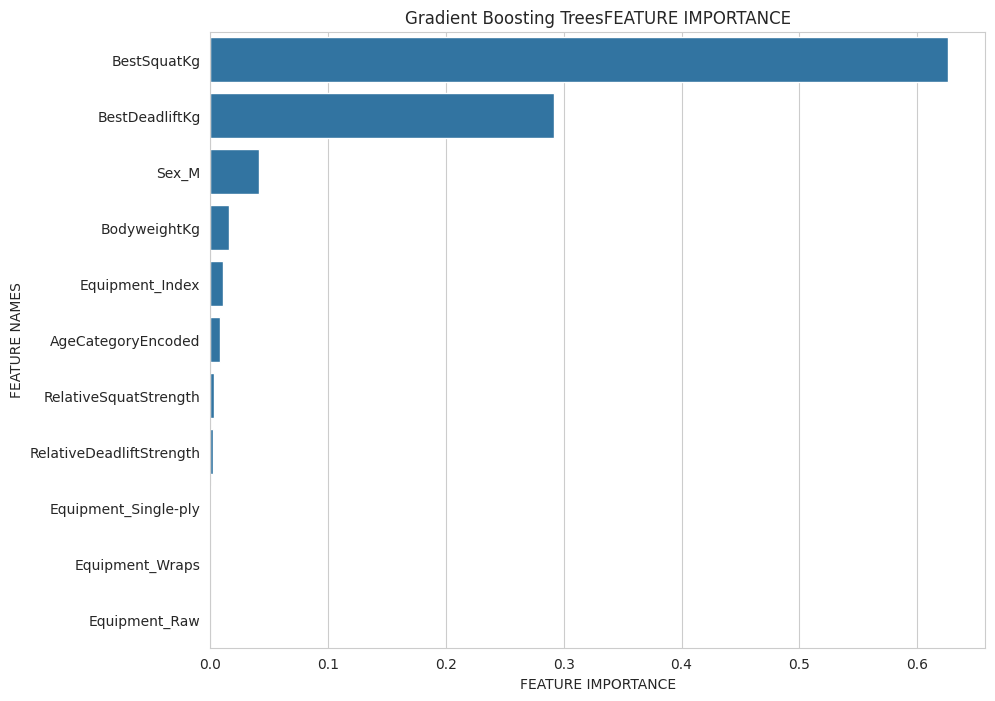

In [ ]:
plot_feature_importance(importances , names = X_train.columns, model_name= "Gradient Boosting Trees")

Given our model performance, there is still room for improvement.
#### Hyper-parameter Optimization

- **Task:** Your task is to enhance the performance of your Gradient Boosting model by utilizing either RandomizedSearchCV or GridSearchCV for hyperparameter optimization. Begin by selecting the parameters you wish to tune. After determining the optimal parameter values through the search process, instantiate a new Gradient Boosting model using these optimized parameters. Then, evaluate and compare the performance of this optimized model against the original to assess the improvement achieved.

Find the list of parameters in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html).

In [ ]:
#To-Do: Hyper-parameter Optimization


### Conclusion


In conclusion, this lecture has provided a comprehensive guide on employing tree-based regression models, specifically focusing on Decision Trees, to predict the bench press weights of powerlifting athletes. We've journeyed through crucial steps, starting from data preprocessing, where we prepared the BenchPress Weight dataset for analysis, to feature selection, where we identified the most relevant variables influencing bench press performance. We then progressed to model training, where we constructed our regression models, followed by hyperparameter tuning to optimize its performance. Finally, we evaluated our model to assess its predictive accuracy.

As we wrap up this lesson, we set the stage for your upcoming term project, where you'll apply the principles of regression analysis to a new dataset. This project will challenge you to integrate the knowledge and skills you've acquired, pushing you to explore innovative approaches to regression problems.

Additionally, lesson review notes on regression will soon be released. These notes will serve as a valuable resource, summarizing key concepts and techniques discussed throughout our lectures on regression, and providing you with a reference point to solidify your understanding and aid in your project work.